<a href="https://colab.research.google.com/github/selmakurtovic4/ZavrsniRad/blob/main/ZavrsniRad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Izvorni github: https://github.com/sarthak15169/Deep-Music

In [ ]:
    notes=json.load(open('./Data/notes.json'))

    print('Notes processed')
    network_in, network_out= prepare_sequences(notes)
    print("input")


In [ ]:
  print(len(network_out[0]))

315


Notes processed
Input and Output processed
Model created
Training in progress
Epoch 1/200
1167/1167 [==============================] - 27s 15ms/step - loss: 1531723.5000
Epoch 2/200
1167/1167 [==============================] - 18s 16ms/step - loss: 9465588.0000
Epoch 3/200
1167/1167 [==============================] - 18s 16ms/step - loss: 22758932.0000
Epoch 4/200
1167/1167 [==============================] - 18s 15ms/step - loss: 39508820.0000
Epoch 5/200
1167/1167 [==============================] - 18s 15ms/step - loss: 56361012.0000
Epoch 6/200
1167/1167 [==============================] - 18s 15ms/step - loss: 72160256.0000
Epoch 7/200
1167/1167 [==============================] - 18s 15ms/step - loss: 88999144.0000
Epoch 8/200
1167/1167 [==============================] - 18s 15ms/step - loss: 107168472.0000
Epoch 9/200
1167/1167 [==============================] - 18s 15ms/step - loss: 126802360.0000
Epoch 10/200
1167/1167 [==============================] - 18s 15ms/step - loss: 14827

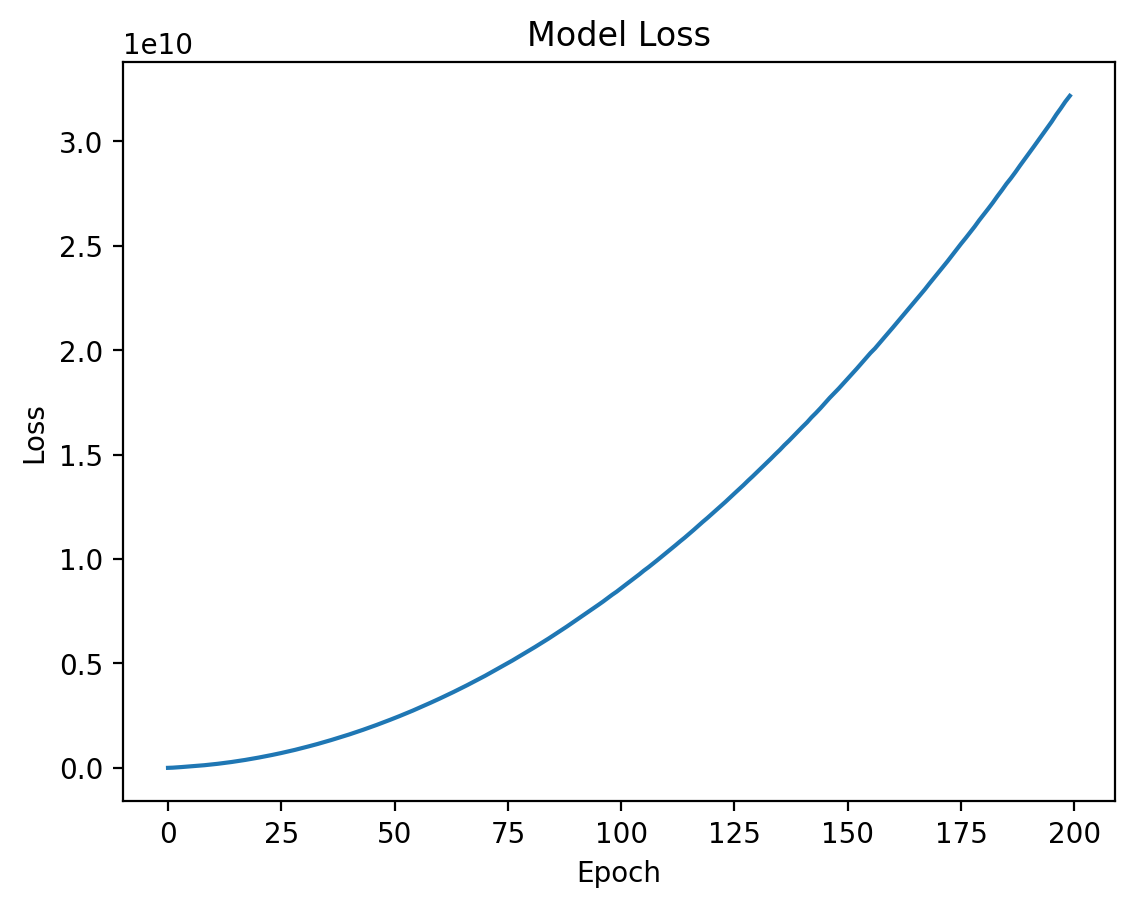

KeyError: ignored

In [12]:
train_model()

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os
!git clone https://github.com/selmakurtovic4/ZavrsniRad.git
os.chdir('/content/ZavrsniRad')

Cloning into 'ZavrsniRad'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 295 (delta 5), reused 0 (delta 0), pack-reused 223
Receiving objects: 100% (295/295), 2.43 MiB | 4.87 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [3]:
import sys
import re
import numpy as np
import pandas as pd
import music21
from glob import glob
import IPython
from tqdm import tqdm
import pickle
from keras.utils import np_utils
import os
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten
from keras.callbacks import ModelCheckpoint
import json
import matplotlib.pyplot as plt


In [ ]:
songs = glob('./Datasets/TheBeatles/*.mid')

In [4]:
def prepare_duration_dictionary(notes, unique_pitch_num):
     durations = [element["duration"] for element in notes]
     duration_names = sorted(set(item for item in durations))
     unique_duration_num=len(duration_names)
     duration_to_int = {note: value for value, note in enumerate(duration_names, start=unique_pitch_num)}
     return  unique_duration_num,duration_to_int


In [5]:
def prepare_pitch_dictionary(notes):
     pitches = [element["pitch"] for element in notes]
     pitch_names = sorted(set(item for item in pitches))
     unique_count=len(pitch_names)
     pitch_to_int = dict((note, number) for number, note in enumerate(pitch_names))
     return unique_count,pitch_to_int


In [6]:
def transform_duration_value(duration):
   num=1
   base_value= 1/16
   middle=1/32
   decimalValue=1.0
   while(duration > base_value):
    duration=duration-base_value
    num=num+1
    decimalValue=duration
   if(decimalValue<middle):
    num=num-1
   duration=num/16
   return duration

In [7]:
def prepare_duration_array(notes):
  durations = [element["duration"] for element in notes]
  #transform to real numbers
  for note in notes:
    note["duration"]=round(eval(note["duration"]),2)
  #transform to 1/16 based values
  base_value= 1/16
  comparing_value=0.001
  for index, note in enumerate(notes):
    duration=note["duration"]
    if(duration<1):
      new_value=transform_duration_value(duration)
      note["duration"] = new_value
    else:
      #create new notes, min 2
      is_it_float=0
      additional_value=duration-int(duration)
      if(additional_value>0):
         is_it_float=1
         #additional_value=round(additional_value,2)
      numberOfNotes=int(duration)+ is_it_float
      numberOfInsertedNotes=numberOfNotes-1
      note["duration"]=1
      for i in range(0,numberOfInsertedNotes-1):
        element={"pitch": note["pitch"], "duration": 1, "played":0 }
        notes.insert(index+1,element)
      if(is_it_float):
        new_duration=transform_duration_value(additional_value)
        element={"pitch": note["pitch"], "duration": new_duration, "played":0 }
        notes.insert(index+numberOfInsertedNotes,element)


In [ ]:
    notes=json.load(open('./Data/notes.json'))
    notes=notes[:60]
    print(notes)
    print('Notes processed')
    network_in, network_out= prepare_sequences(notes)
    print("input")
    print(network_in[0])

In [8]:
def prepare_sequences(notes):

    sequence_length = 50
    prepare_duration_array(notes)
    unique_pitch_num, pitch_dictionary = prepare_pitch_dictionary(notes)
    unique_duration_num, duration_dictionary = prepare_duration_dictionary(notes, unique_pitch_num+1)

    network_input = []
    network_output=[]

    network_output_played=[]

    for i in range(0, len(notes) - sequence_length, 1):
        notes_sequence = notes[i: i + sequence_length]

        sequence_in = []
        for note in notes_sequence:
            sequence_in.append(pitch_dictionary[note["pitch"]])
            sequence_in.append(duration_dictionary[note["duration"] ])
            sequence_in.append(note["played"])
        network_input.append(sequence_in)


        network_output_pitch=pitch_dictionary[notes[i + sequence_length]["pitch"]]
        network_output_duration=duration_dictionary[notes[i + sequence_length]["duration"]]

        network_output_played=notes[i + sequence_length]["played"]


          #encode

        length=unique_duration_num+unique_pitch_num+1

        network_output_pitch= np_utils.to_categorical(network_output_pitch, num_classes=length)

        network_output_duration=np_utils.to_categorical(network_output_duration, num_classes=length)





        #combine

        combined_list = network_output_pitch + network_output_duration

        combined_list= np.append(combined_list, network_output_played)

        network_output.append(combined_list)


    # scaling of pitch input
    network_input=np.array(network_input)
    network_input = network_input.astype(float)
    const=100
    for row in network_input:
        row[::3] /= unique_pitch_num
        for index,element in enumerate(row):
          if(index-1)%3==0:
            row[index]/=const

    # reshape the input into a format compatible with LSTM layers
    num_of_sequences = len(network_input)
    input_length=sequence_length * 3
    network_input = np.reshape(network_input, (num_of_sequences, input_length, 1))

    return (network_input, network_output)


In [9]:
def create_network(network_in, unique_pitch_num, unique_duration_num):
    model = Sequential()
    model.add(LSTM(128, input_shape=network_in.shape[1:], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.3))
    output_length=unique_pitch_num+unique_duration_num+1+1
    model.add(Dense(output_length))
    model.add(Activation('sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [10]:
def train(model, network_input, network_output, epochs):
    # Create checkpoint to save the best model weights.
    filepath = 'weights.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)

    history=model.fit(network_input, network_output, epochs=epochs, batch_size=50, callbacks=[checkpoint])
    return history

In [11]:
def train_model():
    epochs = 200
    #notes = get_notes()
    notes=json.load(open('./Data/notes.json'))
    print('Notes processed')
    network_in, network_out= prepare_sequences(notes)
    unique_pitch_num= len(set( [item['pitch'] for item in notes] ))
    unique_duration_num =len(set( [item['duration'] for item in notes] ))
    print('Input and Output processed')
    network_out=np.array(network_out)
    with tf.device(device_name):
      model = create_network(network_in, unique_pitch_num, unique_duration_num)
    print('Model created')
    print('Training in progress')
    history=train(model, network_in, network_out,epochs)
    print('Training completed')
   # Visualize training loss
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Visualize training accuracy
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    return model


In [ ]:
def generate():
    with open('Data/notes', 'rb') as filepath:
      notes = pickle.load(filepath)
    pitchnames = sorted(set(item for item in notes))
    n_vocab = len(set(notes))

    print('Initiating music generation process.......')

    network_input = get_inputSequences(notes, pitchnames, n_vocab)
    model = create_network(network_input, n_vocab)
    print('Loading Model weights.....')
    model.load_weights('weights.hdf5')
    print('Model Loaded')
    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
    create_midi(prediction_output)

**GET_INPUTSEQUENCES**

---
Ova metoda radi sve kao i prepare_sequence osim sto nema output niz nego samo input, nije mi jasno sto je potrebna uopste


In [ ]:
def get_inputSequences(notes, pitchnames, n_vocab):

    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 50
    network_input = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])

    n_patterns = len(network_input)
    print ('n_patterns ', n_patterns)
    print ('n_vocab ', n_vocab)

    # reshape the input into a format comatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

    # normalize input
    network_input = network_input / float(n_vocab)

    return (network_input)


In [ ]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    start = np.random.randint(0, len(network_input)-1)
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    pattern = network_input[start]
    print ('pattern.shape', pattern.shape)
    prediction_output = []

    print('Generating notes........')

    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        # Predicted output is the argmax(P(h|D))
        index = np.argmax(prediction)
        # Mapping the predicted interger back to the corresponding note
        result = int_to_note[index]
        # Storing the predicted output
        prediction_output.append(result)

        pattern = np.append(pattern, index)
        # Next input to the model
        pattern = pattern[1:len(pattern)]

    print('Notes Generated...')
    return prediction_output

**CREATE_MIDI**

---





1.   Prolazi se kroz sve elemente prediction_outputa petljom
2.   Sad ima definisano sta se desava ukoliko je element chord, onda se taj string razdvoji po tacki da bi dobili pojedinacne note i prave se novi objekti Note i oni se dodaju objektu Chord i konacno se to dodaje u output_notes.
3. Definisano je sta se desava ako je element nota, definise se instrument klavir i dodaje u output_notes
4. Offset oznacava udaljenost neke note od pocetka ako sam dobro shvatila, tako da se ovdje povecava za 0.5 prilikom svake nove note
5. Napravi se stream od output_notes-a i to se zapise kao midi fajl u folder GeneratedMusic




In [ ]:
def create_midi(prediction_output):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    folder_path = '/content/ZavrsniRad/GeneratedSongs'
    number = len(os.listdir(folder_path))+1
    filename = f"test{number}.mid"
    midi_stream.write('midi', fp=filename)

In [ ]:

import os

file_path = './Data/notes.json'  # Replace with the actual path to your JSON file
file_size = os.path.getsize(file_path)
print(file_size/1024**3)

0.001682540401816368


In [ ]:
# Train model
train_model()
# Generate notes
#generate()

In [ ]:
import pickle
import os
os.chdir('/content/ZavrsniRad/Data')
with open('notes.pickle', 'rb') as file:
    notes = pickle.load(file)
print(notes)

['F#3', '0.5', 'E3', '0.25', 'D3', '0.25', 'B2', '0.5', 'A2', '0.25', 'D2', '1.25', 'D2', '0.5', 'A2', '0.25', 'D2', '1.25', 'D2', '0.25', 'A2', '0.25', 'D2', '1.25', 'D2', '0.5', 'A2', '0.25', 'D2', '1.25', 'D2', '0.5', 'A2', '0.25', 'D2', '1.25', 'D2', '0.5', 'A2', '0.25', 'D2', '1.25', 'D2', '0.5', 'A2', '0.25', 'D2', '1.25', 'D2', '0.25', 'A2', '0.25', 'D2', '1.25', 'D2', '0.25', 'A2', '0.25', 'G2', '2.0', 'B2', '2.0', 'D3', '2.0', 'G3', '2.0', 'D2', '1.25', 'D2', '0.5', 'A2', '0.25', 'D2', '1.25', 'D2', '0.25', 'A2', '0.25', 'G2', '2.0', 'B2', '2.0', 'D3', '2.0', 'G3', '2.0', 'D2', '1.25', 'D2', '0.5', 'A2', '0.5', 'D2', '1.25', 'D2', '0.25', 'A2', '0.25', 'D2', '1.25', 'D2', '0.5', 'A2', '0.25', 'D2', '1.25', 'D2', '0.25', 'A2', '0.25', 'D2', '1.25', 'D2', '0.5', 'A2', '0.25', 'D2', '1.25', 'D2', '0.5', 'A2', '0.25', 'D2', '1.25', 'D2', '0.5', 'A2', '0.25', 'D2', '1.25', 'D2', '0.5', 'A2', '0.25', 'D2', '1.25', 'D2', '0.25', 'A2', '0.25', 'D2', '1.25', 'D2', '0.25', 'A2', '0.25',

In [ ]:
import pickle
from music21 import converter, instrument, note, chord

def get_notes(songs):
    notes = []
    for file in songs:
        try:
            midi = converter.parse(file)
            notes_to_parse = []
            try:
                Score = instrument.partitionByInstrument(midi)
            except:
                pass
            if Score and len(Score)>1: # if parts have instrument parts and if it has more than one instrument
                notes_to_parse = Score.parts[1].recurse()
            else:
                notes_to_parse = midi.flat.notes

            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    element={"pitch": str(element.pitch), "duration": str(element.duration.quarterLength), "played":1 }
                    notes.append(element)
                elif isinstance(element, chord.Chord):
                    normalOrderChord='.'.join(str(n) for n in element.normalOrder)
                    element={"pitch":  normalOrderChord, "duration": str(element.duration.quarterLength), "played":1 }
                    notes.append(element)
                elif isinstance(element, note.Rest):
                    element={"pitch": "r", "duration": str(element.duration.quarterLength), "played":1 }
                    notes.append(element)
        except Exception as e:
            print(f"Error parsing MIDI file {file}: {e}")
            continue

    # Save the notes to a file
    with open('Data/notes.json', 'w') as filepath:
        json.dump(notes, filepath)



    return notes


In [ ]:
import pickle
import os
os.chdir('/content/ZavrsniRad/Data')
with open('notes.pickle', 'rb') as file:
    notes = pickle.load(file)
print(notes)

['F#3', 'E3', 'D3', 'B2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'G2', 'B2', 'D3', 'G3', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'G2', 'B2', 'D3', 'G3', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'G2', 'B2', 'D3', 'G3', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'G2', 'B2', 'D3', 'G3', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'B1', 'B1', 'B-1', 'B-1', 'A1', 'A1', 'B1', 'G1', 'G1', 'G1', 'D2', 'D2', 'G1', 'G1', 'F#1', 'D2', 'D2', 'G1', 'G1', 'F#1', 'D2', 'D2', 'D2', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'G1', 'G1', 'G1', 'D2', 'D2', 'G1', 'G1', 'F#1', 'D2', 'D2', 'G1', 'G1', 'F#1', 'D2', 'D2', 'D2', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'A1', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A2', 'D2', 'D2', 'A

In [ ]:
import pickle
import os
os.chdir('/content/ZavrsniRad/Data')
with open('notes.json', 'rb') as file:
    notes = pickle.load(file)
print(notes)

[{'pitch': 'r', 'duration': '4.0'}, {'pitch': 'r', 'duration': '4.0'}, {'pitch': 'r', 'duration': '4.0'}, {'pitch': 'r', 'duration': '4.0'}, {'pitch': 'r', 'duration': '4.0'}, {'pitch': 'r', 'duration': '4.0'}, {'pitch': 'r', 'duration': '4.0'}, {'pitch': 'r', 'duration': '4.0'}, {'pitch': 'r', 'duration': '4.0'}, {'pitch': 'r', 'duration': '4.0'}, {'pitch': 'r', 'duration': '4.0'}, {'pitch': 'r', 'duration': '0.5'}, {'pitch': 'F#3', 'duration': '0.5'}, {'pitch': 'E3', 'duration': '0.25'}, {'pitch': 'r', 'duration': '0.75'}, {'pitch': 'D3', 'duration': '0.25'}, {'pitch': 'r', 'duration': '0.25'}, {'pitch': 'B2', 'duration': '0.5'}, {'pitch': 'r', 'duration': '0.5'}, {'pitch': 'A2', 'duration': '0.25'}, {'pitch': 'r', 'duration': '0.25'}, {'pitch': 'D2', 'duration': '1.25'}, {'pitch': 'r', 'duration': '0.25'}, {'pitch': 'D2', 'duration': '0.5'}, {'pitch': 'r', 'duration': '1.5'}, {'pitch': 'A2', 'duration': '0.25'}, {'pitch': 'r', 'duration': '0.25'}, {'pitch': 'D2', 'duration': '1.25'}

**GET_NOTES:**

---





1.   Prolazi petljom kroz sve pjesme u datasetu
2.   Svaku pjesmu konvertuje u Stream object
3.   instrument.partitionByInstrument(midi) vraca Score objekat koji je ustvari lista Part objekata. Svaki Part objekat je za odredjeni instrument, recimo za prvu pjesmu ovako izgleda lista:

* <music21.stream.Part Electric Organ>
* <music21.stream.Part electric piano>
* <music21.stream.Part Electric Piano>
* <music21.stream.Part acoustic piano>
* <music21.stream.Part Piano>
* <music21.stream.Part lead guitar>
* <music21.stream.Part Electric Guitar>
* <music21.stream.Part acoustic guitar>
* <music21.stream.Part Acoustic Guitar>
* <music21.stream.Part bass>
* <music21.stream.Part Acoustic Bass>
* <music21.stream.Part 0x7f5c9676e0b0>
---
Svaka pjesma u ovom datasetu ima drugacije instrumente i raspored


4. Ukoliko pjesma ima vise instrumenata pristupamo instrumentu 2 i koristeci recurse() dobijamo sve elemente tog Part-a, sto ukljucuje note, chords, rests...
5. Ukoliko pjesma ima jedan Part onda koristimo flat da dobijemo jedam stream, umjesto da imamo Score pa unutar njega Part, zatim note filtrira to i ostaju samo note
6. Prolazimo kroz cijelu listu notes_to_parse i dodajemo pitch note u niz notes
7. Zapisuju se note i akordi u file notes, odnosno njihov pitch
8. Ovako izgleda notes:
['G4', 'G4', 'F5', 'D5', 'F5', 'D5', 'E5', 'C5', 'E5', 'C5', 'D5', 'B4', 'C3', 'D3', 'F3', 'D2', 'C3', 'F3', 'C3', 'D2', 'D3', 'F3', 'C3', 'D3', 'F3', 'D2', 'C3', 'F3', 'C3', 'D2', 'D3', 'F3', 'G4', 'D4', 'B3', 'G3', 'G4', 'D2', 'G3', 'G4', 'D3', 'G4', 'D2', 'G3', 'A4', 'F#4'...











**PREPARE_SEQUENCE:**

---

  Argumenti su: notes-lista nota koju vraca getNotes() i n_vocab-broj jedinstvenih nota u toj listi




---



1.   u pitchnames se izdvoje svi pitchevi koji postoje u fajlu notes i sortiraju abecedno
3.   note_to_int je dictionary u kojem su parovi naziv note i njen redni broj u nizu pitchnames
4. Prolazimo petljom kroz sve note u fajlu notes
5. sequence_in je lista nota duzine 50
6. sequence_out je element nakon niza  sequence_in u fajlu
7. network_input je matrica ciji su elementi nizovi od 50 elemenata.U ovoj petlji, njoj dodajemo sequence_in nakon sto se konvertuju stringovi u odgovarajuce brojeve iz dictionary-a
8. network_output je niz koji ima elemenata onliko koliko i network_input, samo je on jednodimenzionalan. Njegovi elementi predstavljaju sljedece note nakon elementa niza network_input odgovarajuceg indeksa
9. network_input treba biti 3D niz zbog LSTM mreze, pa to radimo pomocu np.reshape.
10. One-hot enkodiranje network_output-a, network_output ce sad biti matrica ciji su elementi nizovi od n_vocab clanova(ukupan broj svih nota prisutnih u datasetu) i brojevi ce biti prikazani tako sto ce element koji ima indeks koji je jednak tom broju biti 1, a sve ostalo 0



**GENERATE_NOTES**

---


1.   Bira se neki random broj u rasponu od 0 do velicine network_inputa
2.   Varijabli pattern dodijelimo niz koji ima indeks prethodno izabranog broja u network_inputu
3. Sada se u petlji generise 500 nota na sljedeci nacin:


*   prediction_input se prilagodi ulaznom sloju
*   koristeci model.predict dobijemo numpy niz u kojem se nalaze vjerovatnoce za svaku notu i ima velicinu n_vocab
*   varijabli index dodijelimo clan niza koji ima najvecu vjerovatnocu
*  iz dictionary-a int_to_note nadjemo notu koja odgovara indexu
* tu notu dodamo nizu pattern koji sluzi kao input za model i uklonimo prvi clan niza kako ni sekvenca i dalje imala duzinu 50
* sve ide ispocetka




